# Illustrating the results, multidimensional case

Import everything necessary

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import scipy
import seaborn
from tqdm import tqdm
import yfinance as yf
from scipy.stats import norm
from optimization_functions import *
from results_functions import *
from functions_multidim import *
%load_ext autoreload
%autoreload 2
%aimport optimization_functions
%aimport results_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the trained neural networks

The number of trained periods

In [23]:
T=10

The considered stocks

In [24]:
stocks = ["GOOGL","EBAY","AMZN","MSFT","AAPL"]
d = len(stocks)

Create empty dictionaries

In [25]:
Returns_train_tf_dict = {}
Returns_test1_tf_dict = {}
Returns_test2_tf_dict = {}
S_train_dict = {}
S_test1_dict = {}
S_test2_dict = {}

Create training and test periods

In [26]:
for s in stocks:
    S_train = yf.download(s, start="2010-01-02", end="2020-02-01")
    S_train = S_train.dropna()
    S_train = S_train.reset_index()
    S_train = S_train[["Date","Close"]]
    S_train_dict[s] = S_train
    
    Returns_train = S_train["Close"].diff() / S_train["Close"].shift(1)
    Returns_train = Returns_train.dropna()
    # A Tensorflow Adaption
    Returns_train_tf_dict[s] = tf.reshape(Returns_train,(1,len(Returns_train)))

    S_test1 = yf.download(s, start="2020-02-01", end="2020-04-16")
    S_test1 = S_test1.dropna()
    S_test1 = S_test1.reset_index()
    S_test1 = S_test1[["Date","Close"]]
    S_test1_dict[s] = S_test1
    
    Returns_test1 = S_test1["Close"].diff() / S_test1["Close"].shift(1)
    Returns_test1 = Returns_test1.dropna()
    # A Tensorflow Adaption
    Returns_test1_tf_dict[s]  = tf.reshape(Returns_test1,(1,len(Returns_test1)))
    
    S_test2 = yf.download(s, start="2020-04-16", end="2020-06-29")
    S_test2 = S_test2.dropna()
    S_test2 = S_test2.reset_index()
    S_test2 = S_test2[["Date","Close"]]
    S_test2_dict[s] = S_test2

    Returns_test2 = S_test2["Close"].diff() / S_test2["Close"].shift(1)
    Returns_test2= Returns_test2.dropna()
    # A Tensorflow Adaption
    Returns_test2_tf_dict[s]  = tf.reshape(Returns_test2,(1,len(Returns_test2)))

Returns_train_tf = tf.concat([Returns_train_tf_dict[s] for s in stocks],0)
Returns_test1_tf = tf.concat([Returns_test1_tf_dict[s] for s in stocks],0)
Returns_test12_tf = tf.concat([Returns_test2_tf_dict[s] for s in stocks],0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

The estimated covariance matrix

In [27]:
cov = estimate_covariance_matrix(np.transpose(Returns_train_tf.numpy()))
cov

array([[0.00023442, 0.00011647, 0.00016578, 0.00011755, 0.00011557],
       [0.00011647, 0.00031847, 0.00013813, 0.00010943, 0.00010244],
       [0.00016578, 0.00013813, 0.00038073, 0.00013553, 0.00012419],
       [0.00011755, 0.00010943, 0.00013553, 0.00020457, 0.00010672],
       [0.00011557, 0.00010244, 0.00012419, 0.00010672, 0.00026344]])

Load the trained strategies

In [28]:
a_tilde_5dim = file_load_ndim("Basket","Non-Robust_5dim",T)
a_tilde_5dim_0001 = file_load_ndim("Basket","Robust_5dim_0001",T)
a_tilde_5dim_001 = file_load_ndim("Basket","Robust_5dim_001",T)
a_tilde_5dim_ada= file_load_ndim("Basket","Robust_5dim_adaptive",T)

Depict Training and Testing Periods

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


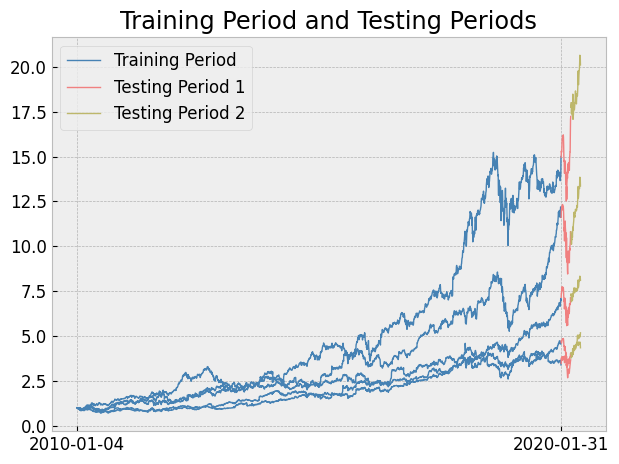

In [29]:
matplotlib.rcParams.update({'font.size': 12})

for s in stocks: 
    S0 = S_train_dict[s]["Close"].iloc[0]
    plt.plot(range(len(S_train_dict[s])),
             S_train_dict[s]["Close"]/S0,label="Training Period",color="steelblue", linewidth=1)
    plt.plot(range(len(S_train_dict[s]),len(S_train_dict[s])+len(S_test1_dict[s])),
             S_test1_dict[s]["Close"]/S0,label="Testing Period 1",color="lightcoral", linewidth=1)
    plt.plot(range(len(S_train_dict[s])+len(S_test1_dict[s]),len(S_train_dict[s])+len(S_test1_dict[s])+len(S_test2_dict[s])),
             S_test2_dict[s]["Close"]/S0,label="Testing Period 2",color="darkkhaki", linewidth=1)
    plt.title("Training Period and Testing Periods")
    
xtick_numbers1 = [0,len(S_train_dict[s])] #,len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)]
plt.xticks(xtick_numbers1, [S_train_dict[s]["Date"].dt.date.iloc[xtick_numbers1[0]],S_train_dict[s]["Date"].dt.date.iloc[xtick_numbers1[1]-1]] )#,S_test1["Date"].dt.date.iloc[0],S_test2["Date"].dt.date.iloc[0]])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:3], labels[:3])  # Only keep the first three elements
plt.grid(True)
plt.tight_layout()
plt.savefig('portfolio_train_test_split.eps', format='eps')
plt.show()

# Evaluation

# 1) Evaluation on Training Data

In [30]:
d1,r1,r2,r3,r4= evaluate_nn_ndim(Returns_train_tf[:,:50],
                                   a_tilde_5dim,
                                   a_tilde_5dim_0001,
                                   a_tilde_5dim_001,
                                 a_tilde_5dim_ada, d,T,cov)

Rewards_1, Rewards_robust_1, Rewards_robust_12, Rewards_robust_ada_12 = r1,r2,r3,r4
d1.round(4).describe()

100%|██████████| 40/40 [01:58<00:00,  2.96s/it]


,Non-Robust,"Robust, eps = 0.0001","Robust, eps = 0.001","Robust, adaptive"
count,40.000000,40.000000,40.000000,40.000000
mean,0.147147,0.724373,0.166985,0.270962
std,0.131587,0.229657,0.109506,0.081226
min,0.002000,0.340300,0.045300,0.105000
25%,0.071075,0.561000,0.093175,0.218375
50%,0.113500,0.738200,0.152000,0.269800
75%,0.192250,0.803325,0.211400,0.334375
max,0.688900,1.428000,0.650200,0.437100


C:\Users\jul_ses\AppData\Local\Temp\ipykernel_14912\1342991638.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.2, 0, 1, 1])  # Adjust the main plot area


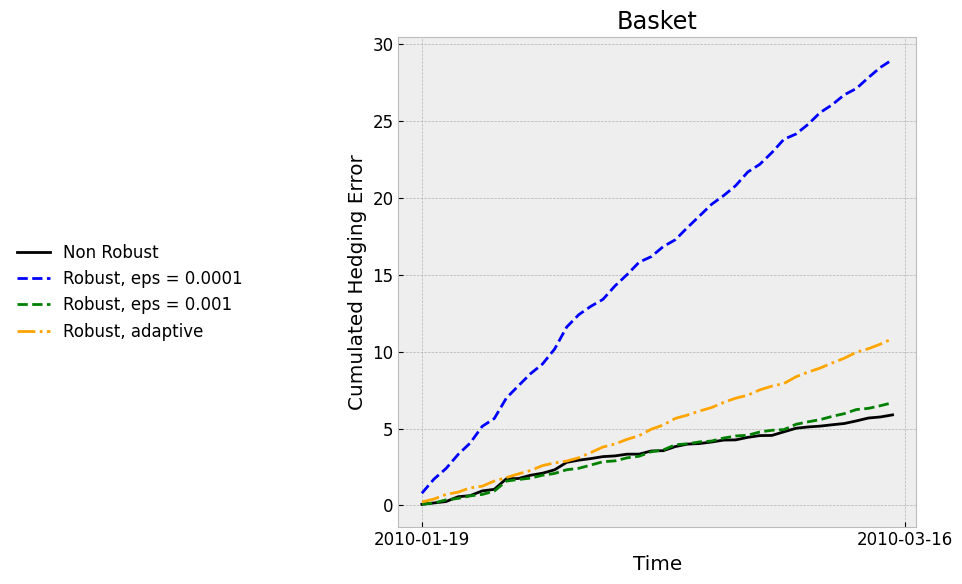

In [31]:
# Create subplots and adjust the figure width to accommodate the legend
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
plt.subplots_adjust(left= 0.2)  # Adjust left margin to make space for the legend

# If there is only one stock, axes is not an iterable array, so we wrap it in a list
axes = [axes]

# Variable to store the handles and labels for the legend
handles, labels = [], []

for ax in axes:
    ax.set_title(f"Basket")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated Hedging Error")
    line1, = ax.plot(np.cumsum(Rewards_1), color="black", label="Non Robust")
    line2, = ax.plot(np.cumsum(Rewards_robust_1), color="blue", label="Robust, eps = 0.0001", linestyle="dashed")
    line3, = ax.plot(np.cumsum(Rewards_robust_12), color="green", label="Robust, eps = 0.001", linestyle="dashed")
    line4, = ax.plot(np.cumsum(Rewards_robust_ada_12), color="orange", label="Robust, adaptive", linestyle="dashdot")  
    # Store handles and labels only once
    if not handles and not labels:
        handles.extend([line1, line2, line3,line4])
        labels.extend([line.get_label() for line in [line1, line2, line3,line4]])

    xtick_numbers_train = [0, len(Rewards_1)]
    ax.set_xticks(xtick_numbers_train)
    ax.set_xticklabels([
        S_train["Date"].dt.date.iloc[xtick_numbers_train[0]+T],
        S_train["Date"].dt.date.iloc[xtick_numbers_train[1] - 1+T]
    ])

    ax.grid(True)

# Add a new axis for the legend to the left of the plots
legend_ax = fig.add_axes([-0.1, 0.1, 0.1, 0.8])  # [left, bottom, width, height]
legend_ax.axis('off')  # Turn off the axis
legend_ax.legend(handles, labels, loc='center', frameon=False)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.2, 0, 1, 1])  # Adjust the main plot area

plt.show()

# 2) Evaluation in Testing Period 1

In [32]:
d2,r1,r2,r3,r4 = evaluate_nn_ndim(Returns_test1_tf[:,:],
                                   a_tilde_5dim,
                                   a_tilde_5dim_0001,
                                   a_tilde_5dim_001,
                                  a_tilde_5dim_ada, d,T,cov)

Rewards_2, Rewards_robust_2, Rewards_robust_22, Rewards_robust_ada_22 = r1,r2,r3,r4
d2.round(4).describe()

100%|██████████| 40/40 [01:24<00:00,  2.10s/it]


,Non-Robust,"Robust, eps = 0.0001","Robust, eps = 0.001","Robust, adaptive"
count,40.000000,40.000000,40.000000,40.000000
mean,0.334610,0.892132,0.293880,0.294505
std,0.312801,0.484704,0.261437,0.187209
min,0.009000,0.090400,0.023700,0.004600
25%,0.102125,0.582425,0.128025,0.164275
50%,0.258450,0.849200,0.225850,0.246750
75%,0.382250,1.202225,0.337650,0.372500
max,1.170400,1.938900,1.110400,0.718900


C:\Users\jul_ses\AppData\Local\Temp\ipykernel_14912\1962000285.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.45, 0, 1, 1])  # Adjust the main plot area


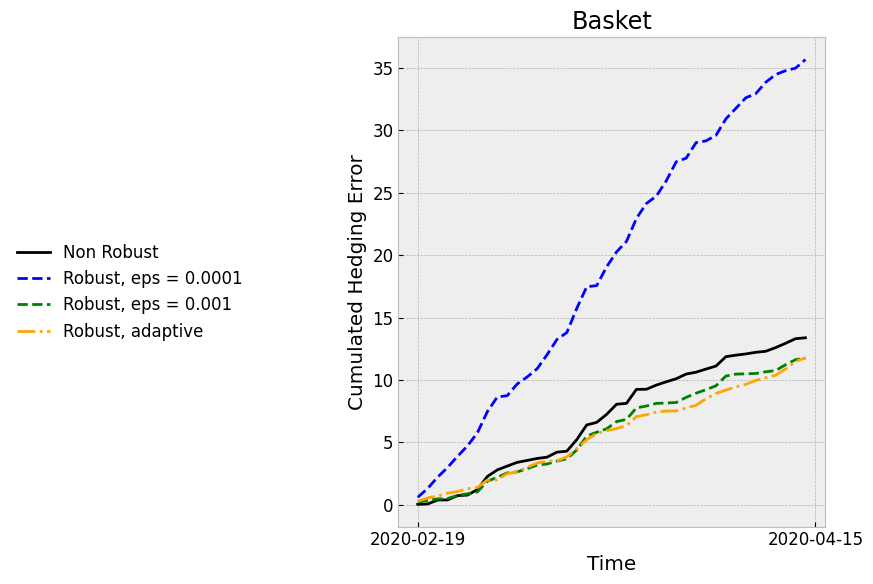

In [37]:
# Create subplots and adjust the figure width to accommodate the legend
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
plt.subplots_adjust(left= 0.4)  # Adjust left margin to make space for the legend

# If there is only one stock, axes is not an iterable array, so we wrap it in a list
axes = [axes]

# Variable to store the handles and labels for the legend
handles, labels = [], []

for ax in axes:
    ax.set_title(f"Basket")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated Hedging Error")
    line1, = ax.plot(np.cumsum(Rewards_2), color="black", label="Non Robust")
    line2, = ax.plot(np.cumsum(Rewards_robust_2), color="blue", label="Robust, eps = 0.0001", linestyle="dashed")
    line3, = ax.plot(np.cumsum(Rewards_robust_22), color="green", label="Robust, eps = 0.001", linestyle="dashed")
    line4, = ax.plot(np.cumsum(Rewards_robust_ada_22), color="orange", label="Robust, adaptive", linestyle="dashdot")
    
    # Store handles and labels only once
    if not handles and not labels:
        handles.extend([line1, line2, line3, line4])
        labels.extend([line.get_label() for line in [line1, line2, line3, line4]])

    xtick_numbers_test1 = [0, len(Rewards_2)]
    ax.set_xticks(xtick_numbers_test1)
    ax.set_xticklabels([
        S_test1["Date"].dt.date.iloc[xtick_numbers_test1[0]+T+1],
        S_test1["Date"].dt.date.iloc[xtick_numbers_test1[1] +T]
    ])

    ax.grid(True)

# Add a new axis for the legend to the left of the plots
legend_ax = fig.add_axes([0.2, 0.1, 0.1, 0.8])  # [left, bottom, width, height]
legend_ax.axis('off')  # Turn off the axis
legend_ax.legend(handles, labels, loc='center', frameon=False)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.45, 0, 1, 1])  # Adjust the main plot area
plt.savefig('Basket_test1.pdf', format='pdf')
plt.show()

### Histogram

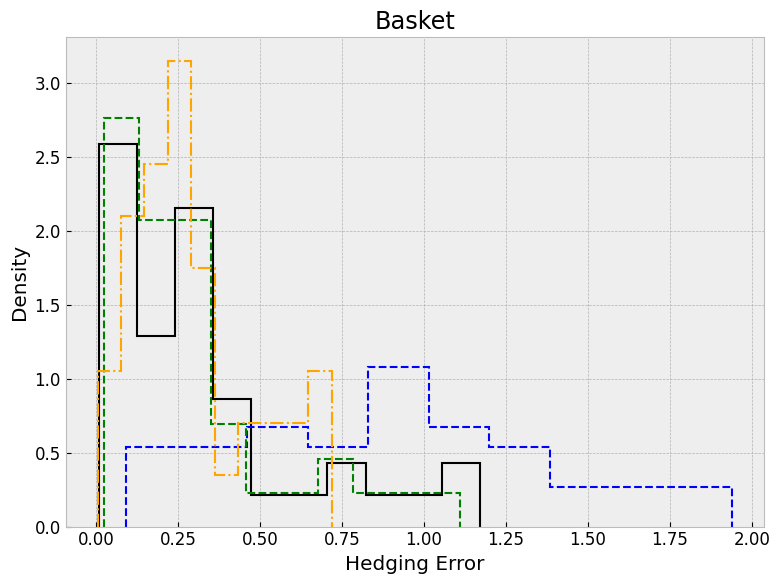

In [35]:
# Create subplots and adjust the figure width to accommodate the legend
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
plt.subplots_adjust(left=0.3)  # Adjust left margin to make space for the legend

# If there is only one stock, axes is not an iterable array, so we wrap it in a list
axes = [axes]

# Variable to store the handles and labels for the legend
handles, labels = [], []

for ax in axes:
    ax.set_title("Basket")
    ax.set_xlabel("Hedging Error")
    ax.set_ylabel("Density")

    line1 = ax.hist(Rewards_2, color="black", label="Non Robust", histtype='step', linewidth=1.5, density=True)
    line2 = ax.hist(Rewards_robust_2, color="blue", label="Robust, eps = 0.0001", linestyle="dashed", histtype='step', linewidth=1.5, density=True)
    line3 = ax.hist(Rewards_robust_22, color="green", label="Robust, eps = 0.001", linestyle="dashed", histtype='step', linewidth=1.5, density=True)
    line4 = ax.hist(Rewards_robust_ada_22, color="orange", label="Robust, adaptive", linestyle="dashdot", histtype='step', linewidth=1.5, density=True)
    # Only need to grab the legend handles from the first call to ax.histlabel="Robust, adaptive", linestyle="dashdot") 
    if not handles:
        handles = [line1[2][0], line2[2][0], line3[2][0]] , line4[2][0]
        labels = ["Non Robust", "Robust, eps = 0.0001", "Robust, eps = 0.001"]

    ax.grid(True)

# Add a new axis for the legend to the left of the plots
#legend_ax = fig.add_axes([0.2, 0.1, 0.1, 0.8])  # [left, bottom, width, height]
#legend_ax.axis('off')  # Hide the axis
#legend_ax.legend(handles, labels, loc='center', frameon=False)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the main plot area

plt.savefig('histogram_Basket_test1.pdf', format='pdf')
plt.show()

# 3) Evaluation in Testing Period 2


In [36]:
d3,r1,r2,r3,r4 = evaluate_nn_ndim(Returns_test12_tf[:,:],
                                   a_tilde_5dim,
                                   a_tilde_5dim_0001,
                                   a_tilde_5dim_001,
                                  a_tilde_5dim_ada, d,T,cov)

Rewards_3, Rewards_robust_3, Rewards_robust_32,Rewards_robust_ada_32 = r1,r2,r3,r4
d3.round(4).describe()

100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


,Non-Robust,"Robust, eps = 0.0001","Robust, eps = 0.001","Robust, adaptive"
count,40.000000,40.000000,40.000000,40.000000
mean,0.186493,0.645210,0.192130,0.301567
std,0.152458,0.294380,0.123636,0.108949
min,0.002400,0.065500,0.001400,0.062200
25%,0.104675,0.501750,0.099750,0.220800
50%,0.147850,0.588850,0.179500,0.325900
75%,0.226875,0.791225,0.250425,0.362200
max,0.797300,1.506700,0.568200,0.534300


C:\Users\jul_ses\AppData\Local\Temp\ipykernel_14912\2079126867.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.45, 0, 1, 1])  # Adjust the main plot area


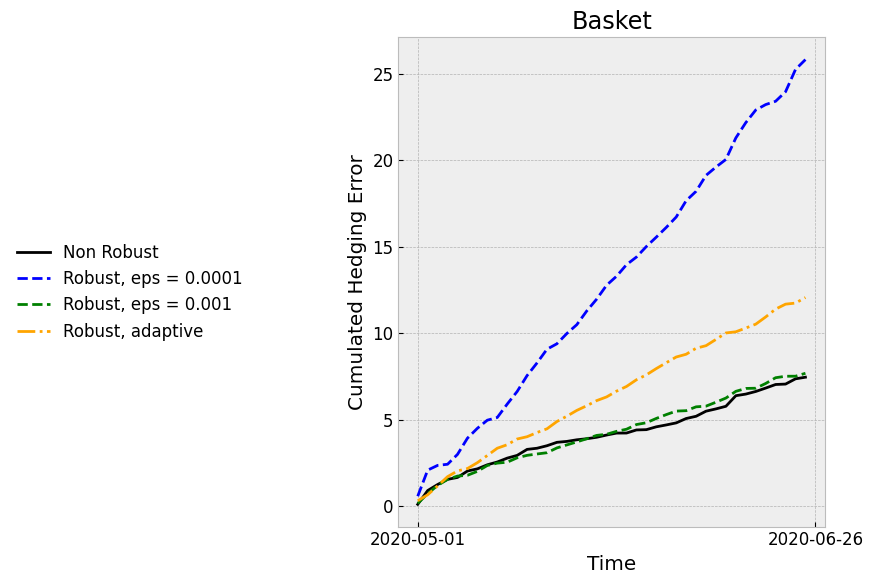

In [38]:
# Create subplots and adjust the figure width to accommodate the legend
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
plt.subplots_adjust(left= 0.4)  # Adjust left margin to make space for the legend

# If there is only one stock, axes is not an iterable array, so we wrap it in a list
axes = [axes]

# Variable to store the handles and labels for the legend
handles, labels = [], []

for ax in axes:
    ax.set_title(f"Basket")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated Hedging Error")
    line1, = ax.plot(np.cumsum(Rewards_3), color="black", label="Non Robust")
    line2, = ax.plot(np.cumsum(Rewards_robust_3), color="blue", label="Robust, eps = 0.0001", linestyle="dashed")
    line3, = ax.plot(np.cumsum(Rewards_robust_32), color="green", label="Robust, eps = 0.001", linestyle="dashed")
    line4, = ax.plot(np.cumsum(Rewards_robust_ada_32), color="orange", label="Robust, adaptive", linestyle="dashdot")      
    # Store handles and labels only once
    if not handles and not labels:
        handles.extend([line1, line2, line3, line4])
        labels.extend([line.get_label() for line in [line1, line2, line3, line4]])

    xtick_numbers_test2 = [0, len(Rewards_3)]
    ax.set_xticks(xtick_numbers_test2)
    ax.set_xticklabels([
        S_test2["Date"].dt.date.iloc[xtick_numbers_test2[0]+T+1],
        S_test2["Date"].dt.date.iloc[xtick_numbers_test2[1] +T]
    ])

    ax.grid(True)

# Add a new axis for the legend to the left of the plots
legend_ax = fig.add_axes([0.2, 0.1, 0.1, 0.8])  # [left, bottom, width, height]
legend_ax.axis('off')  # Turn off the axis
legend_ax.legend(handles, labels, loc='center', frameon=False)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.45, 0, 1, 1])  # Adjust the main plot area
plt.savefig('Basket_test2.pdf', format='pdf')
plt.show()

### Histogram

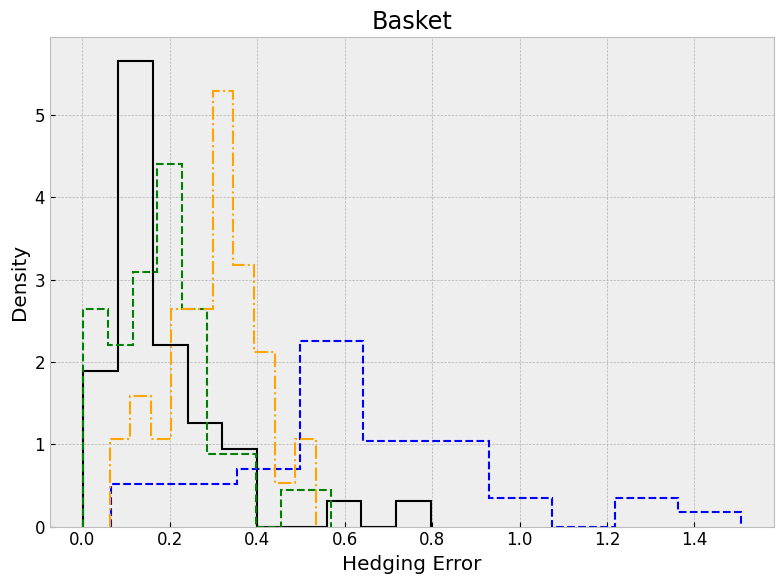

In [39]:
# Create subplots and adjust the figure width to accommodate the legend
fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
plt.subplots_adjust(left=0.3)  # Adjust left margin to make space for the legend

# If there is only one stock, axes is not an iterable array, so we wrap it in a list
axes = [axes]

# Variable to store the handles and labels for the legend
handles, labels = [], []

for ax in axes:
    ax.set_title("Basket")
    ax.set_xlabel("Hedging Error")
    ax.set_ylabel("Density")

    line1 = ax.hist(Rewards_3, color="black", label="Non Robust", histtype='step', linewidth=1.5, density=True)
    line2 = ax.hist(Rewards_robust_3, color="blue", label="Robust, eps = 0.0001", linestyle="dashed", histtype='step', linewidth=1.5, density=True)
    line3 = ax.hist(Rewards_robust_32, color="green", label="Robust, eps = 0.001", linestyle="dashed", histtype='step', linewidth=1.5, density=True)
    line4 = ax.hist(Rewards_robust_ada_32, color="orange", label="Robust, adaptive", linestyle="dashdot", histtype='step', linewidth=1.5, density=True)
    # Only need to grab the legend handles from the first call to ax.hist
    if not handles:
        handles = [line1[2][0], line2[2][0], line3[2][0], line4[2][0]]
        labels = ["Non Robust", "Robust, eps = 0.0001", "Robust, eps = 0.001", "Robust, adaptive"]

    ax.grid(True)

# Add a new axis for the legend to the left of the plots
#legend_ax = fig.add_axes([0.2, 0.1, 0.1, 0.8])  # [left, bottom, width, height]
#legend_ax.axis('off')  # Hide the axis
#legend_ax.legend(handles, labels, loc='center', frameon=False)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the main plot area

plt.savefig('histogram_Basket_test2.pdf', format='pdf')
plt.show()
